# Strategy V3

We aim to find the optimal strategy for the following assets:

0, 1, 6, 10, 12, 14, 16, 17, 24, 28, 32, 36, 38, 39, 43

We first analyse these assets, and try the following strategies for trending/momentum assets:

- Donchian Breakout w/ Trade Dependence

In [33]:
import copy

import numpy as np
import pandas as pd

from typing import List

from pandas.conftest import all_logical_operators

allocated_instruments: List[int] = [0, 1, 6, 10, 12, 14, 16, 17, 24, 28, 32, 36, 38, 39, 43]
commission_fee: float = 0.005


### Price Plotting & Augmented Dickey-Fuller Test for Analysis

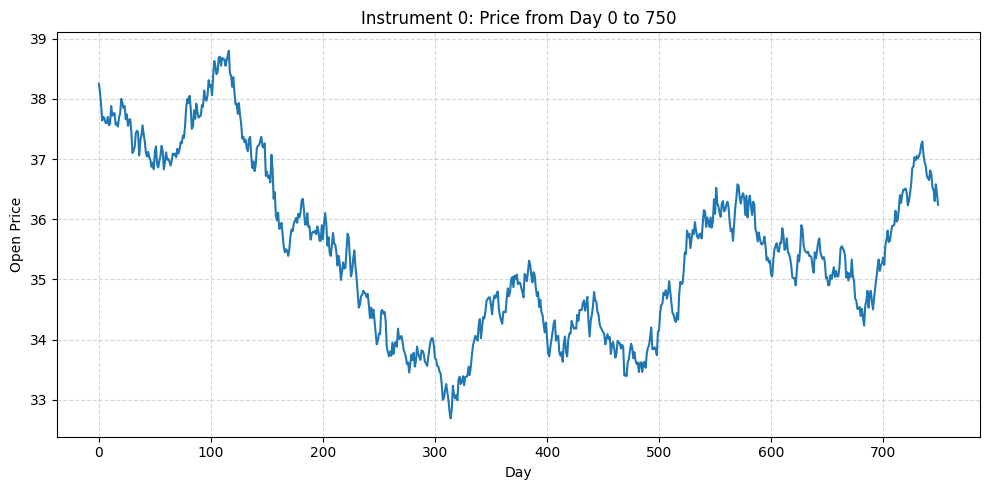

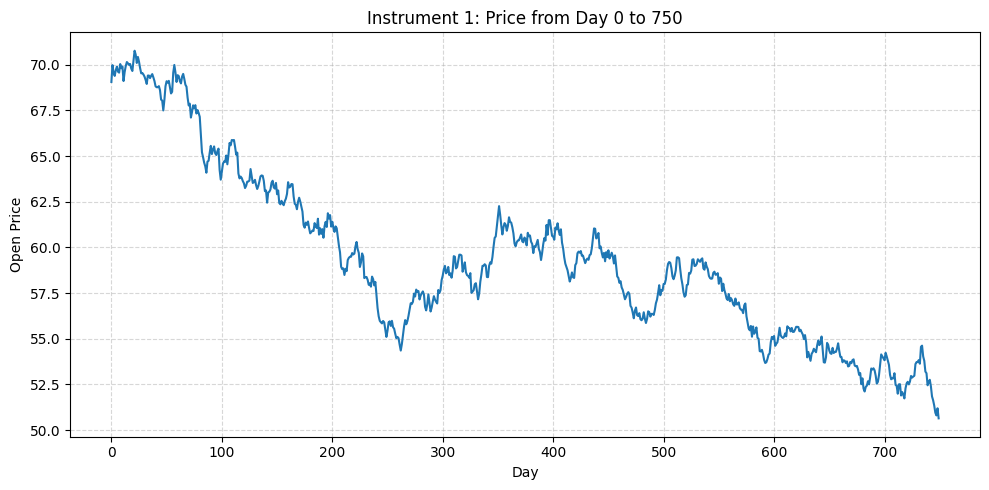

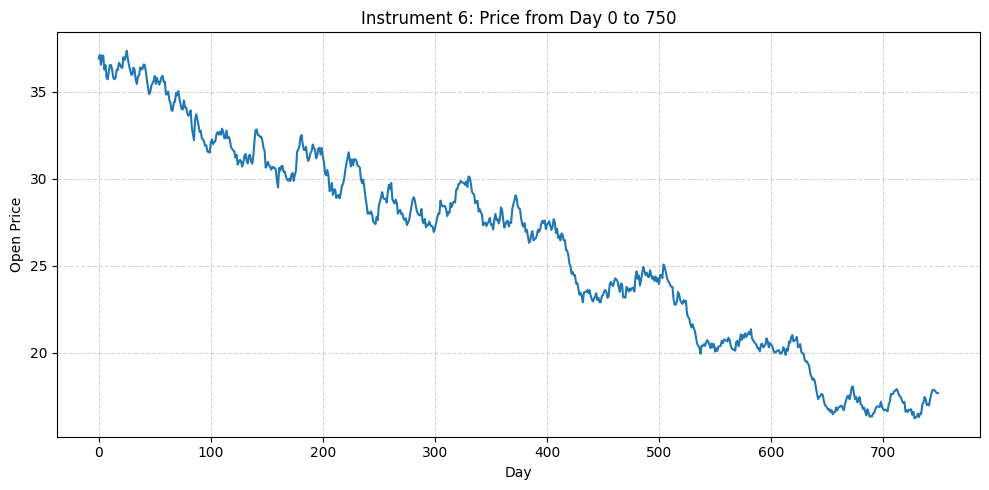

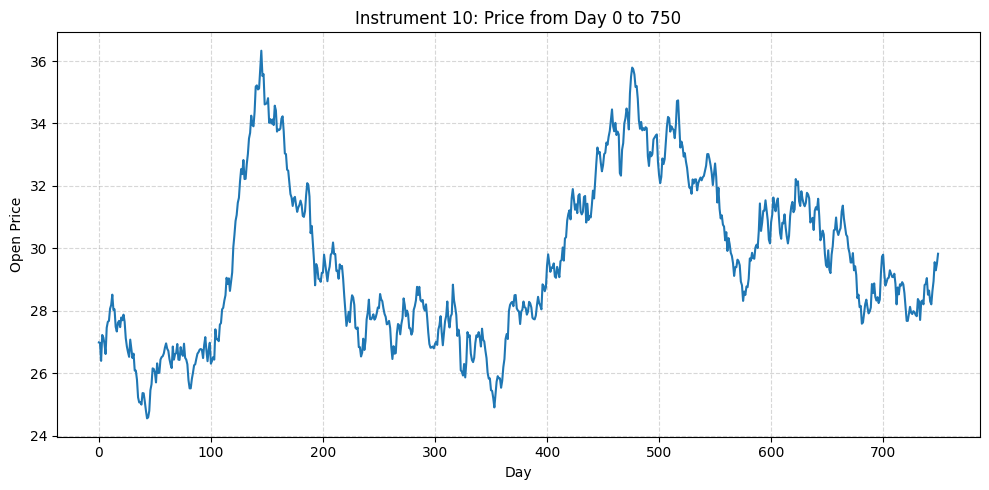

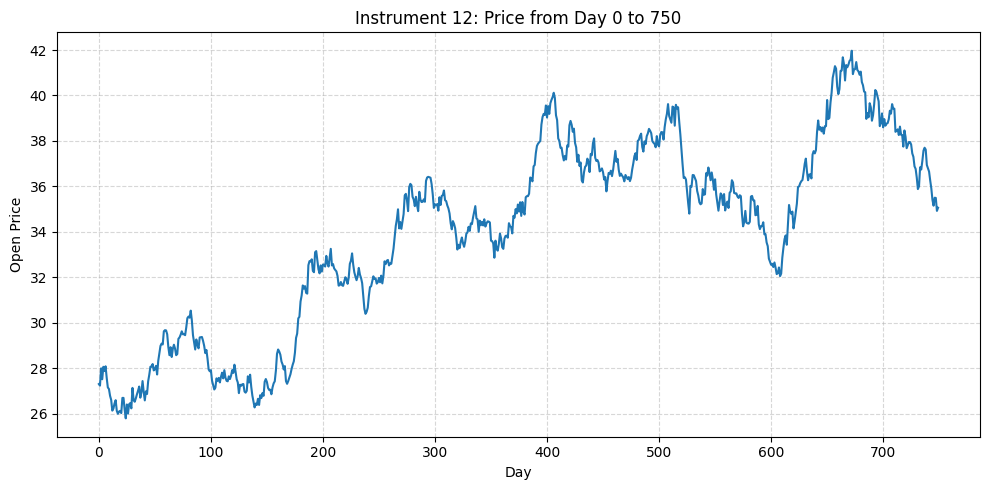

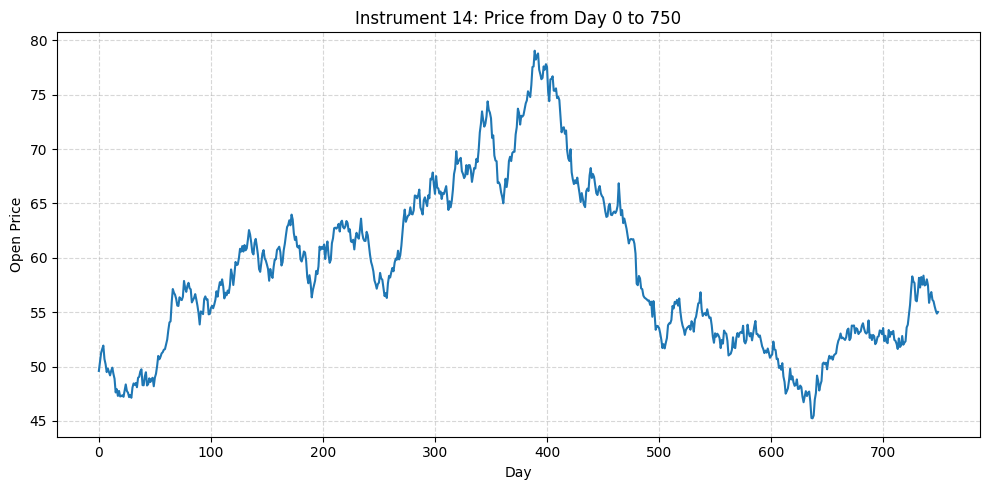

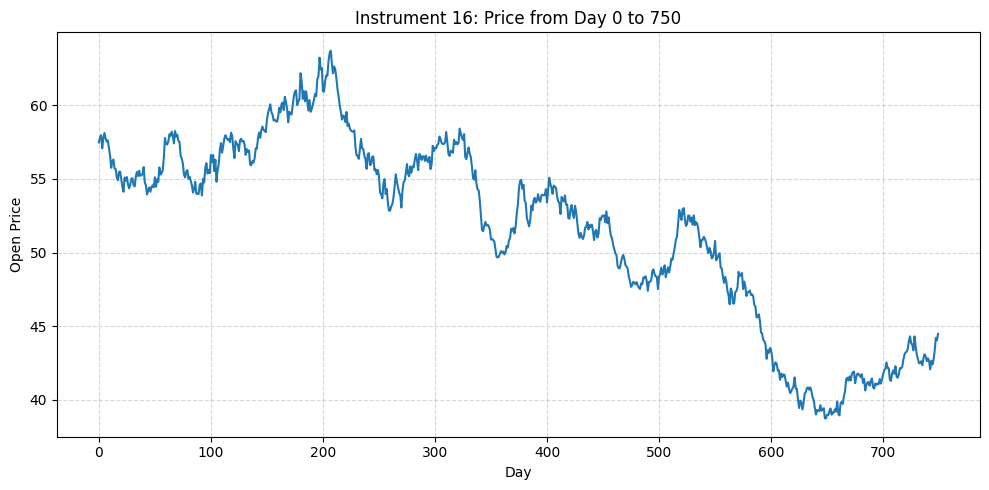

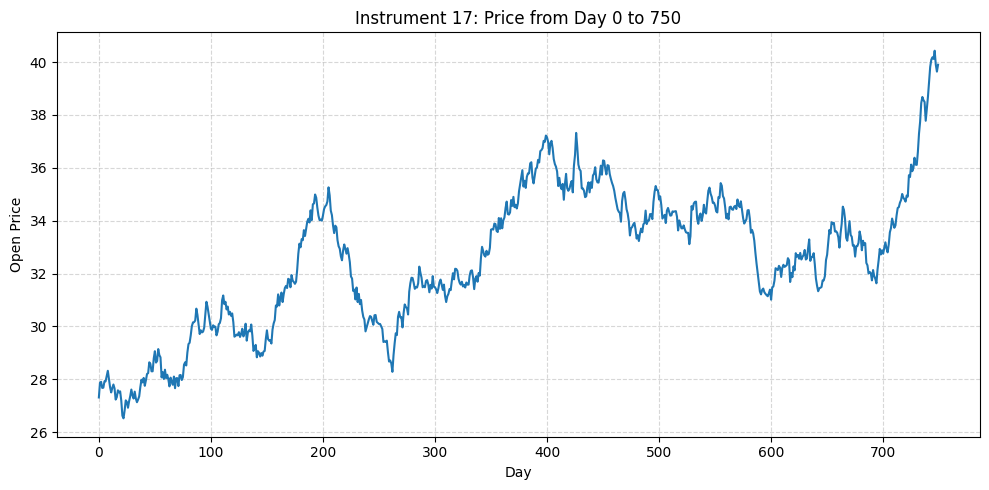

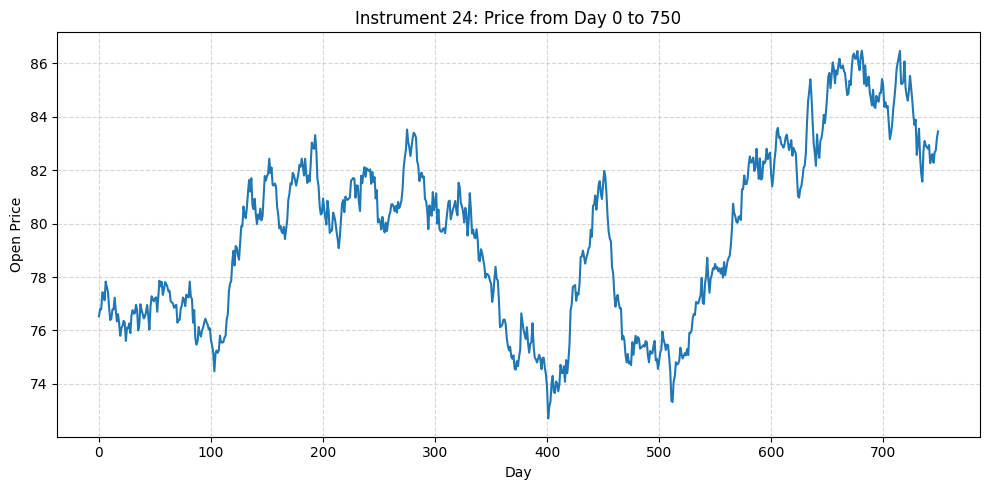

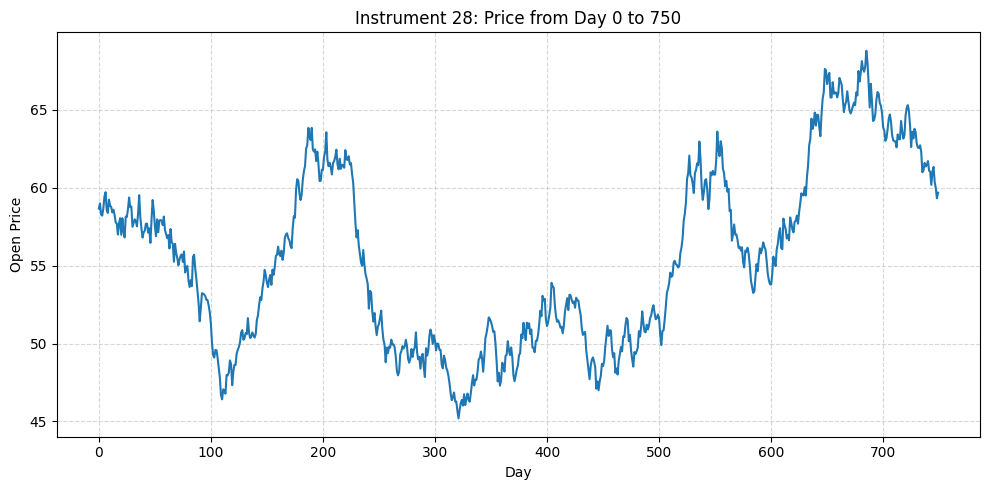

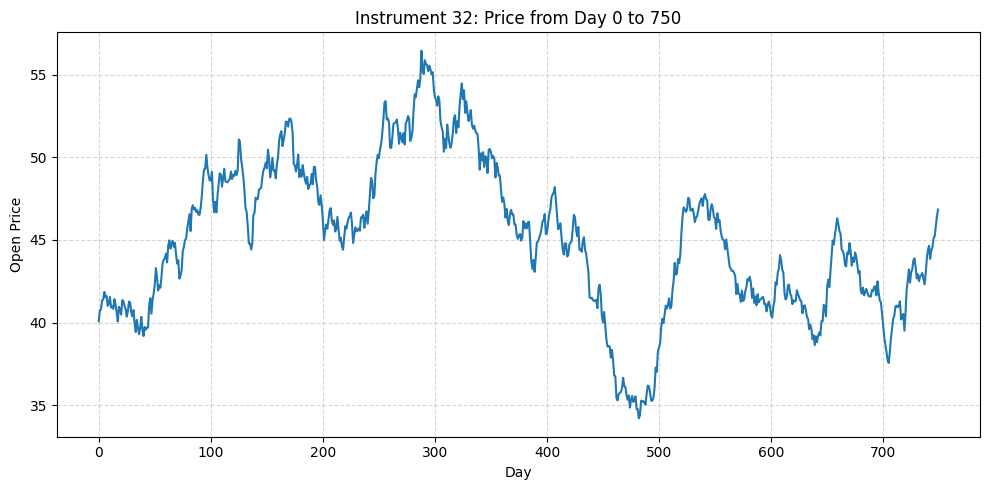

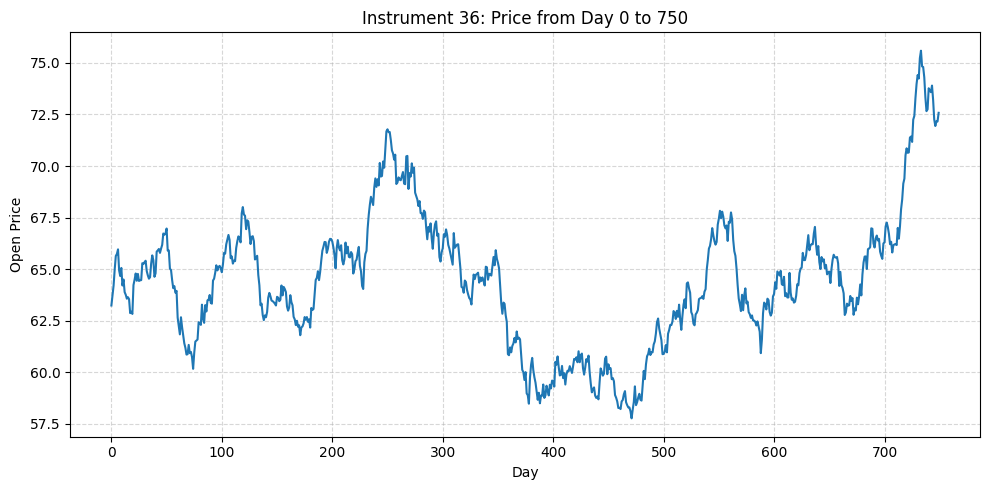

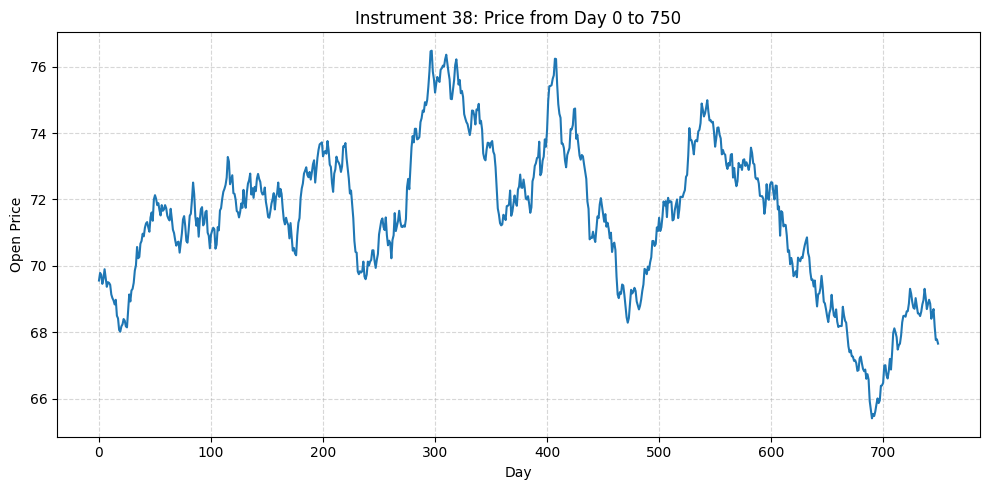

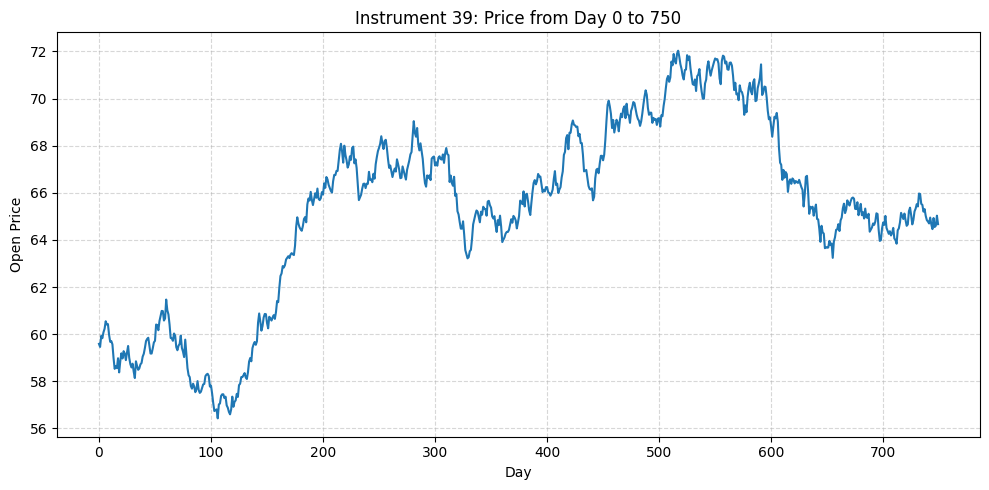

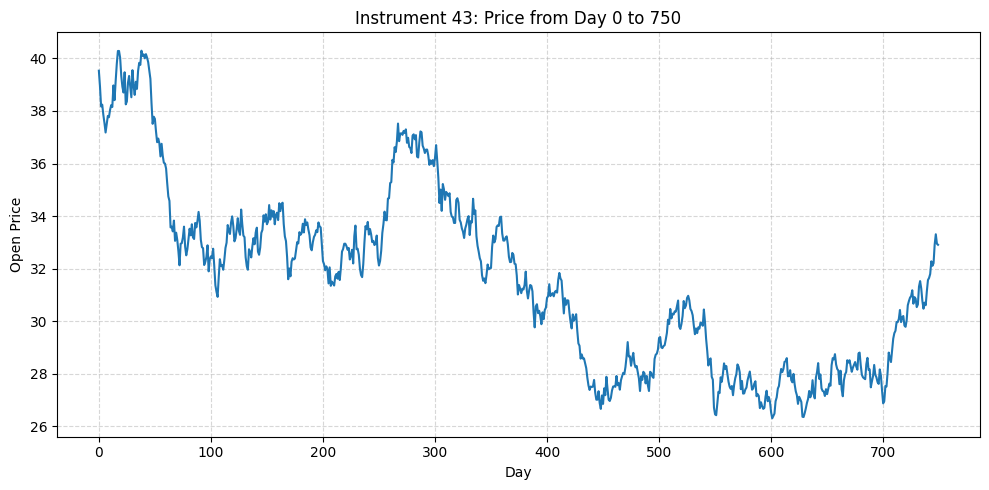

In [34]:
from analysis import MarketData

market_data: MarketData = MarketData(0, 749, "../../prices.txt")

for instrument_no in allocated_instruments:
	market_data.plot_instrument_price_data(instrument_no, 0, 750)

In [35]:
from statsmodels.tsa.stattools import adfuller
from pandas import DataFrame
from numpy import ndarray
from typing import Dict

# Perform an ADF test on each instrument and print the result
def perform_adf_test() -> None:
	raw_prices: DataFrame = pd.read_csv("../../prices.txt", sep=r"\s+", header=None, index_col=None)
	price_history: ndarray = raw_prices.values[:500][:].T
	adf_results: Dict[str, List[float | int]] = {}
	adf_results["Instrument No"] = allocated_instruments
	adf_results["T Statistic"] = []
	adf_results["P-Value"] = []

	for instrument_no in allocated_instruments:
		result = adfuller(price_history[instrument_no], autolag="AIC")
		adf_results["T Statistic"].append(result[0])
		adf_results["P-Value"].append(result[1])

	adf_results_df: DataFrame = pd.DataFrame(adf_results)
	print(adf_results_df.to_string(index=False))

perform_adf_test()

 Instrument No  T Statistic  P-Value
             0    -1.252375 0.650670
             1    -1.617448 0.474067
             6    -1.455952 0.555178
            10    -1.249653 0.651880
            12    -0.883784 0.793266
            14    -1.500742 0.533144
            16    -0.867753 0.798406
            17    -1.482201 0.542297
            24    -1.652114 0.455938
            28    -1.865208 0.348601
            32    -1.212197 0.668327
            36    -1.559961 0.503669
            38    -2.321474 0.165136
            39    -0.874064 0.796393
            43    -1.695322 0.433524


### Helper Functions

In [65]:
from typing import Tuple
from pandas import Series

# Gets historical price data and returns it as a dictionary from instrument no to array of prices
def get_price_history() -> Dict[int, DataFrame]:
	# Get Price Data
	raw_prices: DataFrame = pd.read_csv("../../prices.txt", sep=r"\s+", index_col=None,
			header=None)
	price_data: ndarray = raw_prices.values[:500,:].T

	# Initialise Price History
	price_history: Dict[int, DataFrame] = {}

	# Assign price data to insturments
	for instrument_no in allocated_instruments:
		instrument_price_history: Dict[str, ndarray] = {}
		instrument_price_history["price"] = price_data[instrument_no]
		price_history[instrument_no] = pd.DataFrame(instrument_price_history)


	return price_history

# Gets trade entry and exit times from a signal for each instrument
def get_trades_from_signal(price_history: Dict[int, DataFrame], signals: Dict[int, ndarray]) -> (
	Dict[int, Tuple[DataFrame, DataFrame, DataFrame]]):
	trades: Dict[int, Tuple[DataFrame, DataFrame, DataFrame]] = {}
	
	for instrument_no in allocated_instruments:
		long_trades: List[List[int]] = []
		short_trades: List[List[int]] = []
		
		prices: ndarray = price_history[instrument_no]["price"].to_numpy()
		last_signal: int = 0
		open_trade: List[int] | None = None
		days: Series = price_history[instrument_no].index
		
		for day in range(len(price_history[instrument_no])):
			if signals[instrument_no][day] == 1 and last_signal != 1: # Long Entry
				if open_trade is not None:
					open_trade[2] = days[day]
					open_trade[3] = prices[day]
					short_trades.append(open_trade)
				
				open_trade = [days[day], prices[day], -1, np.nan]
			
			if signals[instrument_no][day] == -1 and last_signal != -1: # Short Entry
				if open_trade is not None:
					open_trade[2] = days[day]
					open_trade[3] = prices[day]
					long_trades.append(open_trade)
				
				open_trade = [days[day], prices[day], -1, np.nan]
			
			if signals[instrument_no][day] == 0 and last_signal == -1: # Short Exit
				open_trade[2] = days[day]
				open_trade[3] = prices[day]
				short_trades.append(open_trade)
				open_trade = None
			
			if signals[instrument_no][day] == 0 and last_signal == 1: # Long Exit
				open_trade[2] = days[day]
				open_trade[3] = prices[day]
				long_trades.append(open_trade)
				open_trade = None
			
			last_signal = signals[instrument_no][day]
		
		long_trades: DataFrame = pd.DataFrame(long_trades, columns=["entry_time", "entry_price", 
			"exit_time", "exit_price"])
		short_trades: DataFrame = pd.DataFrame(short_trades, columns=["entry_time", "entry_price",
																	"exit_time", "exit_price"])
		
		long_trades["return"] = ((long_trades["exit_price"] - long_trades["entry_price"]) / 
			  long_trades["entry_price"])
		short_trades["return"] = (-1 * (short_trades["exit_price"] - short_trades["entry_price"]) 
			  / short_trades["entry_price"])
		
		long_trades = long_trades.set_index("entry_time")
		short_trades = short_trades.set_index("entry_time")
		
		long_trades["type"] = 1
		short_trades["type"] = -1

		non_empty_trades = [df for df in [long_trades, short_trades] if not df.empty]

		if non_empty_trades:
			all_trades = pd.concat(non_empty_trades, ignore_index=True)
		else:
			all_trades = pd.DataFrame(columns=["entry_time", "entry_price", "exit_time", 
				"exit_price", "return"])
			
		all_trades = all_trades.sort_index()
		
		trades[instrument_no] = (long_trades, short_trades, all_trades)
	
	return trades		

# Returns z-score of observed runs
def runs_test(signs: Dict[int, ndarray]) -> Dict[int, float]:
	z_scores: Dict[int, float] = {}
	
	for instrument_no in allocated_instruments:
		if len(signs[instrument_no]) < 3:
			z_scores[instrument_no] = 0
			continue
			
		instrument_signs: ndarray = np.array(signs[instrument_no])
		
		n_pos: int = len(instrument_signs[instrument_signs > 0])
		n_neg: int = len(instrument_signs[instrument_signs < 0])
		n = len(instrument_signs)
		
		if n == 0:
			z_scores[instrument_no] = 0
			continue
		
		# Mean number of expected runs
		mean: float = 2 * n_pos * n_neg / n + 1
		
		# Standard deviation of expected runs
		variance: float = (mean - 1) * (mean - 2) / (n - 1)
		std: float = variance ** 0.5
		
		if std == 0:
			z_scores[instrument_no] = 0
			continue
		
		# Count observed runs
		runs: int = 1
		for i in range(1, len(instrument_signs)):
			if instrument_signs[i] != instrument_signs[i - 1]:
				runs += 1 # Streak broken
		
		# Z-score
		z_scores[instrument_no] = (runs - mean) / std
	
	return z_scores

### Strategies

**Donchian Breakout with Trade Dependence**

In [66]:
def donchian_breakout(price_history: Dict[int, DataFrame], lookbacks: Dict[int, int]) -> Dict[int,
DataFrame]:
	for instrument_no in allocated_instruments:
		# Assign upper and lower band
		price_history[instrument_no]["upper"] = price_history[instrument_no]["price"].rolling(
				lookbacks[instrument_no] - 1).max().shift(1)
		price_history[instrument_no]["lower"] = price_history[instrument_no]["price"].rolling(
				lookbacks[instrument_no] - 1).min().shift(1)

		# Assign signals
		price_history[instrument_no]["signal"] = np.nan
		price_history[instrument_no].loc[price_history[instrument_no]["price"] > price_history[
			instrument_no]["upper"], 'signal']	= 1
		price_history[instrument_no].loc[price_history[instrument_no]["price"] < price_history[
			instrument_no]["lower"], 'signal']	= -1

		price_history[instrument_no]["signal"] = price_history[instrument_no]["signal"].ffill()

	return price_history

### Donchian Breakout Trade Return Runs Test Z-Scores with Lookbacks 12-168

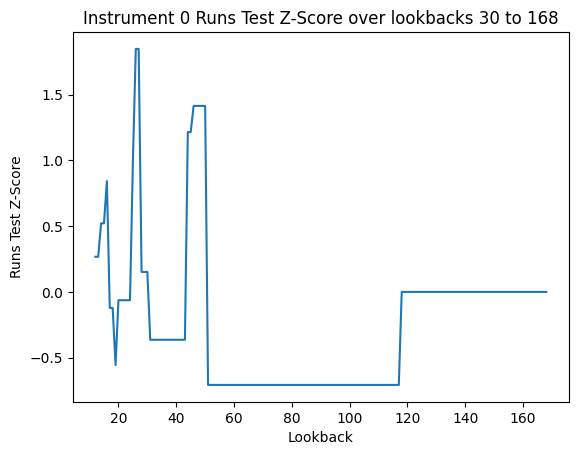

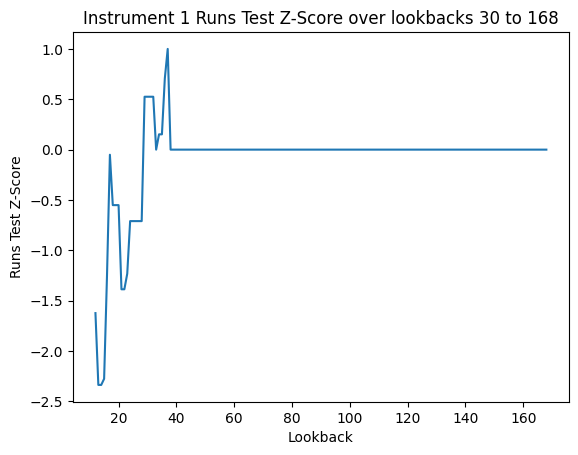

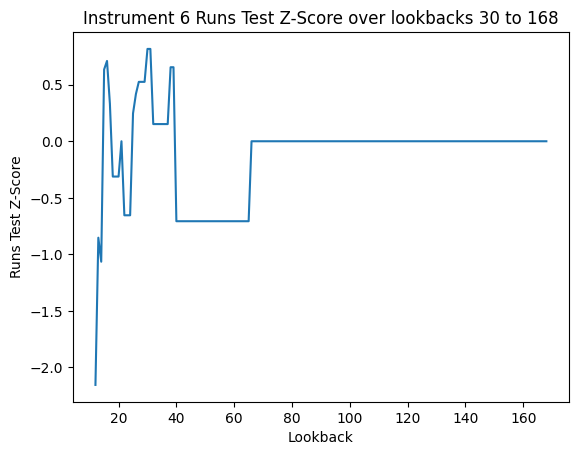

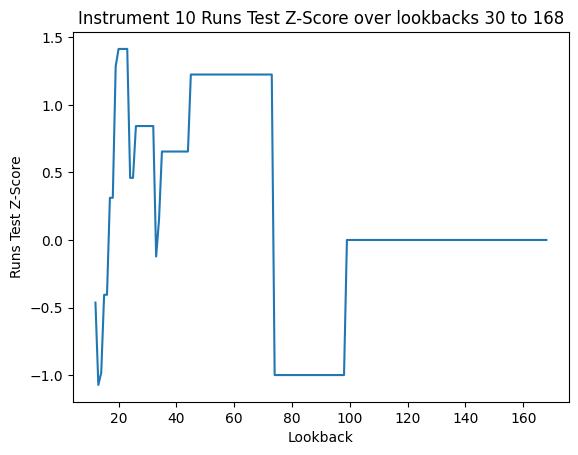

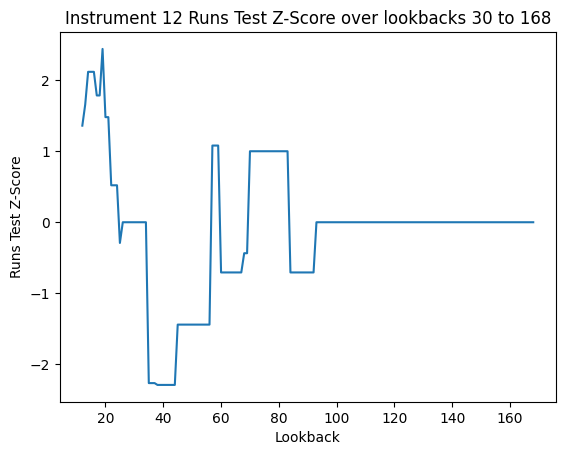

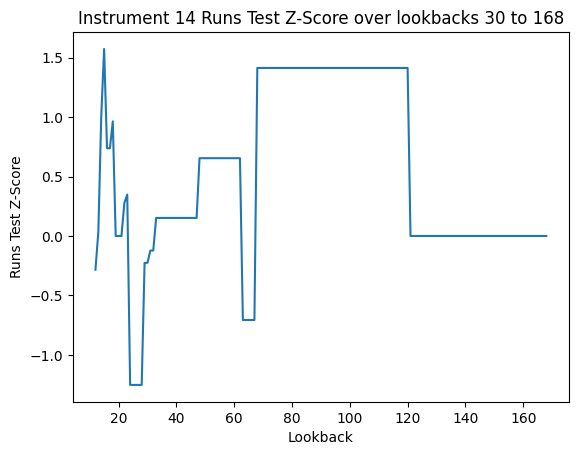

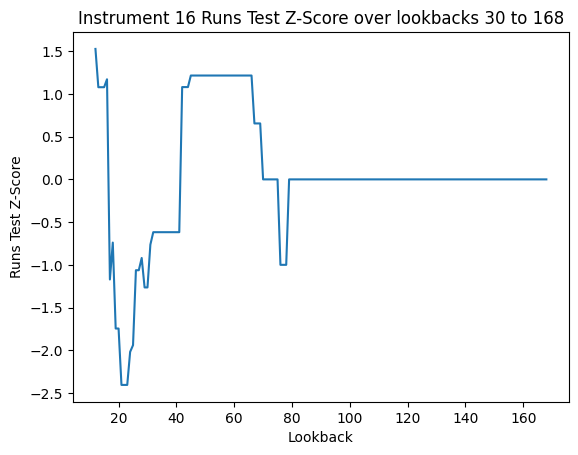

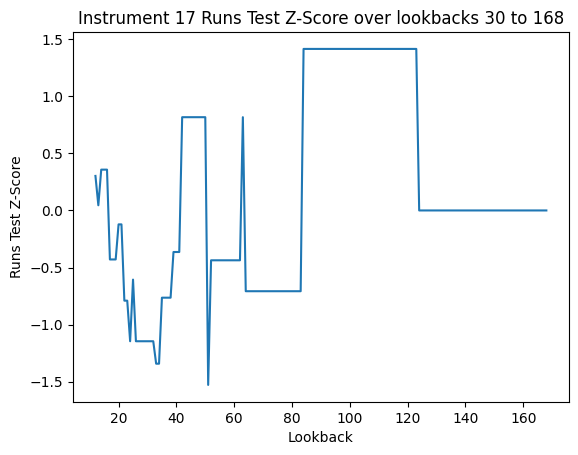

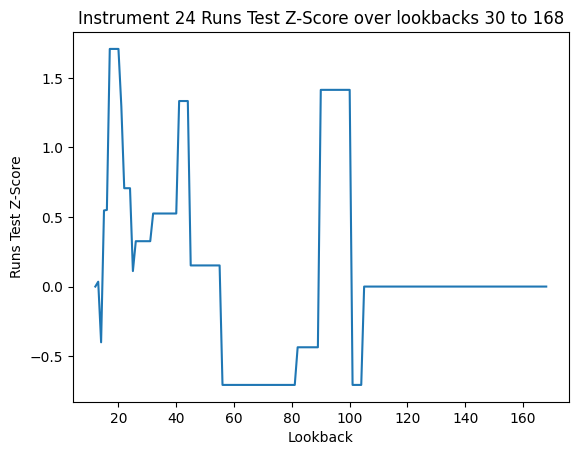

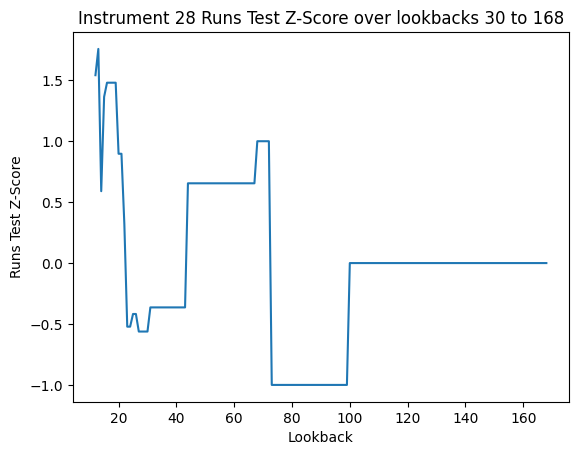

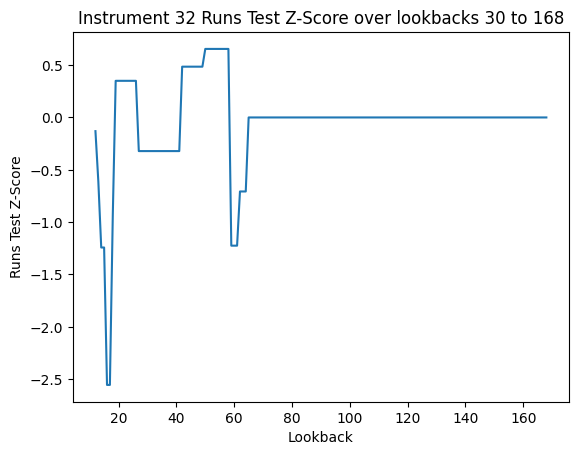

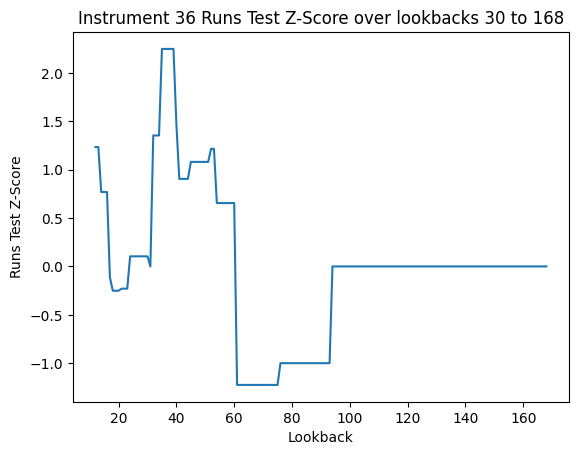

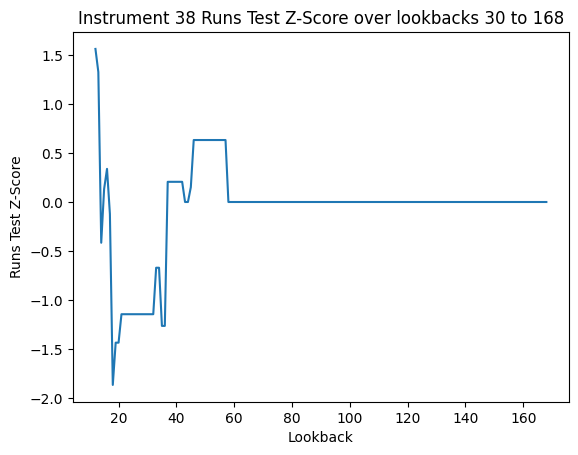

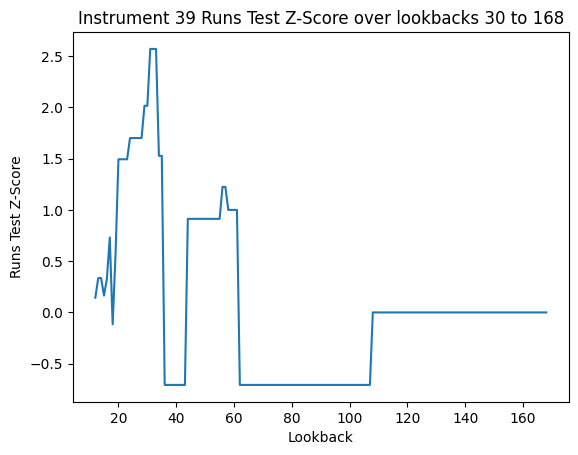

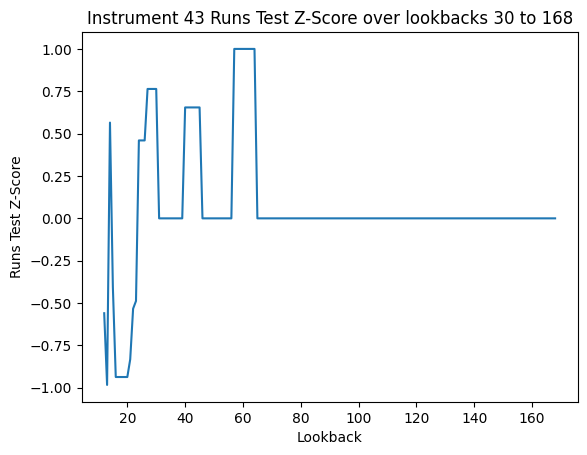

In [68]:
import matplotlib.pyplot as plt

def plot_db_trade_returns(price_history: Dict[int, DataFrame]) -> None:
	all_runs_z: Dict[int, List[float]] = {instrument_no: [] for instrument_no in  
	  allocated_instruments}
	lookbacks_list: List[int] = list(range(12, 169))
	for lookback in lookbacks_list:
		current_lookbacks: Dict[int, int] = {instrument_no: lookback for instrument_no
			 in allocated_instruments}
		strategy_output: Dict[int, DataFrame] = donchian_breakout(copy.deepcopy(price_history),	
			current_lookbacks)
		signals: Dict[int, ndarray] = {instrument_no: strategy_output[instrument_no]["signal"]
			.to_numpy() for instrument_no in allocated_instruments}
		trades: Dict[int, Tuple[DataFrame, DataFrame, DataFrame]] = (get_trades_from_signal
			  (strategy_output, signals))
		signs: Dict[int, ndarray] = {instrument_no: np.sign(trades[instrument_no][2]["return"])
			.to_numpy() for instrument_no in allocated_instruments} 
		
		z_scores: Dict[int, float] = runs_test(signs)
		for instrument_no in allocated_instruments: (all_runs_z[instrument_no].append
			 (z_scores[instrument_no]))
	
	for instrument_no in allocated_instruments:
		pd.Series(all_runs_z[instrument_no],index=lookbacks_list).plot()
		plt.title(f"Instrument {instrument_no} Runs Test Z-Score over lookbacks 30 to 168")
		plt.xlabel("Lookback")
		plt.ylabel("Runs Test Z-Score")
		plt.show()

price_history: Dict[int, DataFrame] = get_price_history()
plot_db_trade_returns(price_history)
	

### Adjusting Trade Signals via Trade Dependence

In [39]:
def last_trade_adj_signal(strategy_output: Dict[int, DataFrame], signals: Dict[int, ndarray],
	last_winner: bool = False) -> Dict[int, ndarray]:
	modified_signals: Dict[int, ndarray] = {}
	
	for instrument_no in allocated_instruments:
		last_type: int = 1 if last_winner else -1
		
		prices: ndarray = strategy_output[instrument_no]["price"].to_numpy()
		modified_signal: ndarray = np.zeros(len(signals[instrument_no]))
		
		long_entry_p: ndarray = np.nan
		short_entry_p: ndarray = np.nan
		last_long: ndarray = np.nan
		last_short: ndarray = np.nan
		
		last_signal = 0
		for i in range(len(prices)):
			if signals[instrument_no][i] == 1 and last_signal != 1: # Long Entry
				long_entry_p = prices[i]
				if not np.isnan(short_entry_p):
					last_short = np.sign(short_entry_p - prices[i])
					short_entry_p = np.nan
				
			if signals[instrument_no][i] == -1 and last_signal != -1: # Short Entry
				short_entry_p = prices[i]
				if not np.isnan(long_entry_p):
					last_long = np.sign(prices[i] - long_entry_p)
					long_entry_p = np.nan
			
			last_signal = signals[instrument_no][i]
			
			if signals[instrument_no][i] == 1 and last_short == last_type:
				modified_signal[i] = 1
			if signals[instrument_no][i] == -1 and last_long and last_type:
				modified_signal[i] = -1
		
		modified_signals[instrument_no] = modified_signal
	
	return modified_signals			

### Comparing Normal Donchian Breakout to Donchian Breakout w/ Trade Dependence

INSTRUMENT: 0
Original Profit Factor: 1.1288855403358975
Last Lose Profit Factor: 1.1910931314252253
Last Win Profit Factor: 1.127533828586622
INSTRUMENT: 1
Original Profit Factor: 1.025017765010356
Last Lose Profit Factor: 1.0237326711609602
Last Win Profit Factor: 1.1308116085655007
INSTRUMENT: 6
Original Profit Factor: 0.8104774999512196
Last Lose Profit Factor: 0.8274604826743737
Last Win Profit Factor: 0.9641978591400838
INSTRUMENT: 10
Original Profit Factor: 1.0191718673150805
Last Lose Profit Factor: 1.062550565167964
Last Win Profit Factor: 0.8738580972792995
INSTRUMENT: 12
Original Profit Factor: 1.0429308859619981
Last Lose Profit Factor: 1.06749957634117
Last Win Profit Factor: 0.8131477749078148
INSTRUMENT: 14
Original Profit Factor: 1.0633985040899583
Last Lose Profit Factor: 1.0633985040899583
Last Win Profit Factor: 1.0070811595428064
INSTRUMENT: 16
Original Profit Factor: 1.0642443243951625
Last Lose Profit Factor: 1.1024548362742075
Last Win Profit Factor: 1.1293334632

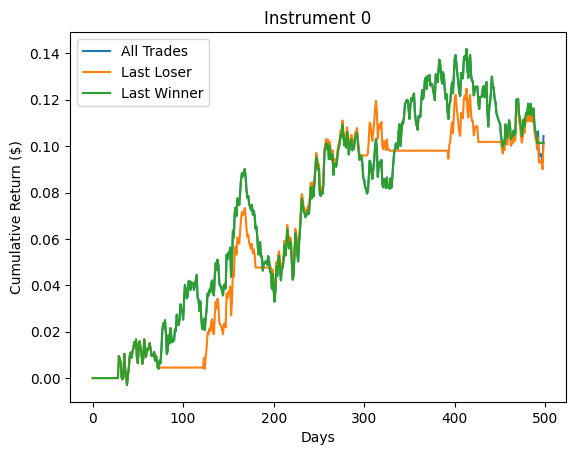

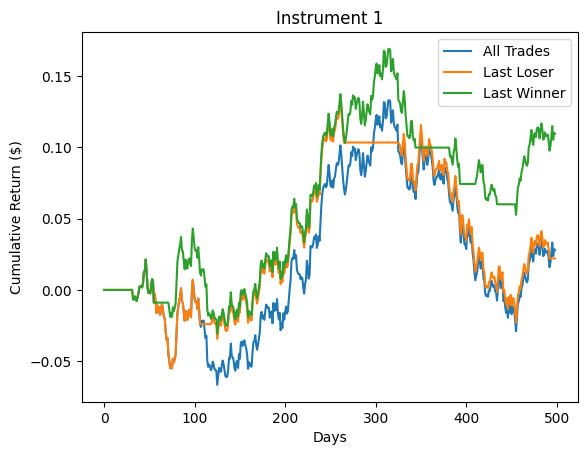

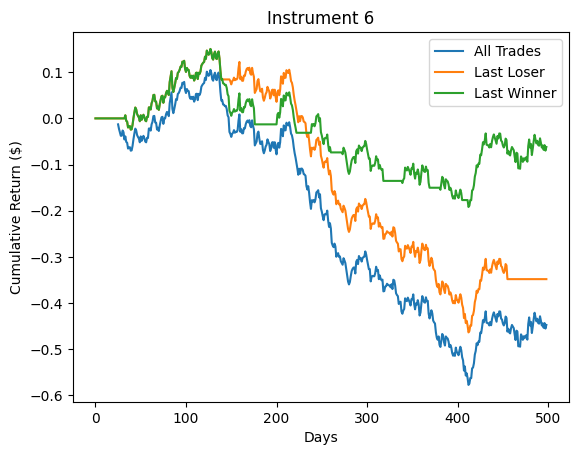

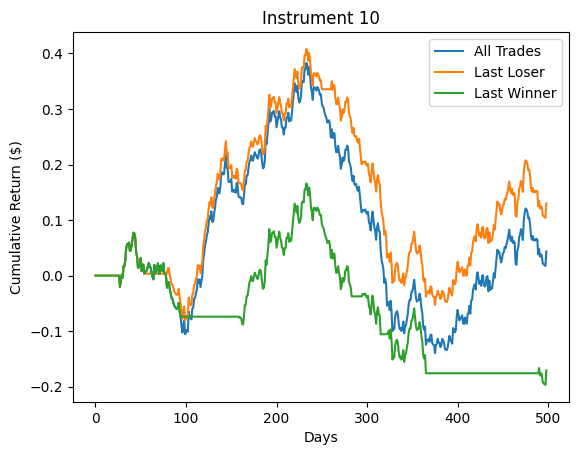

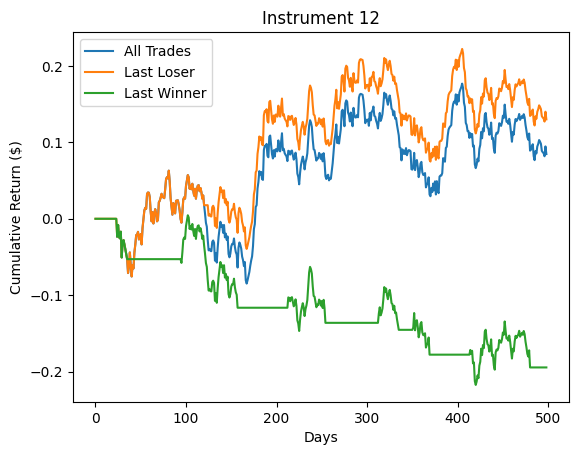

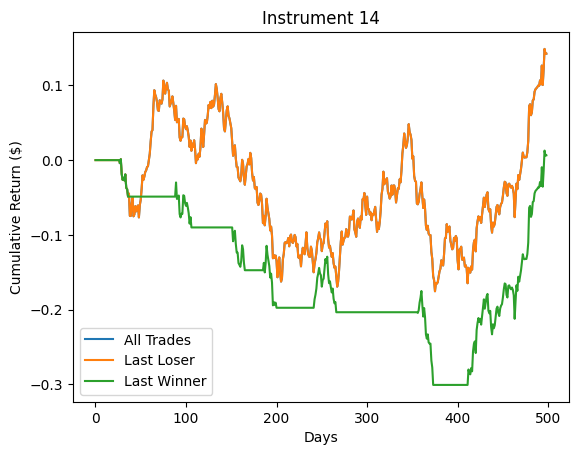

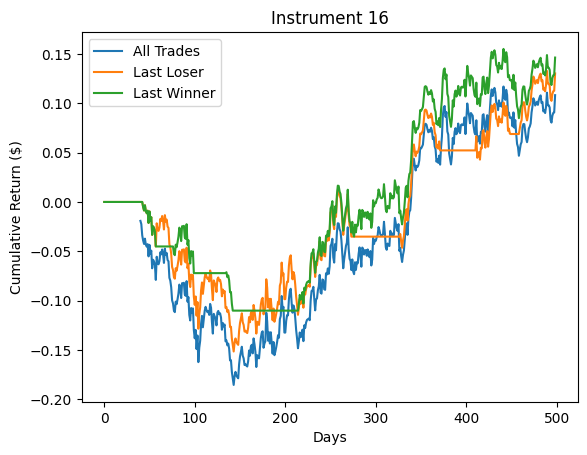

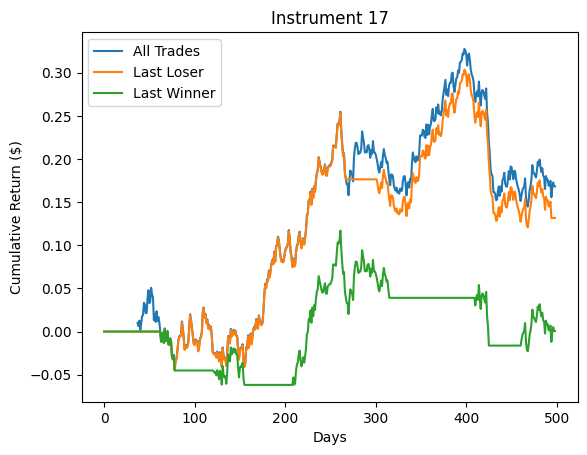

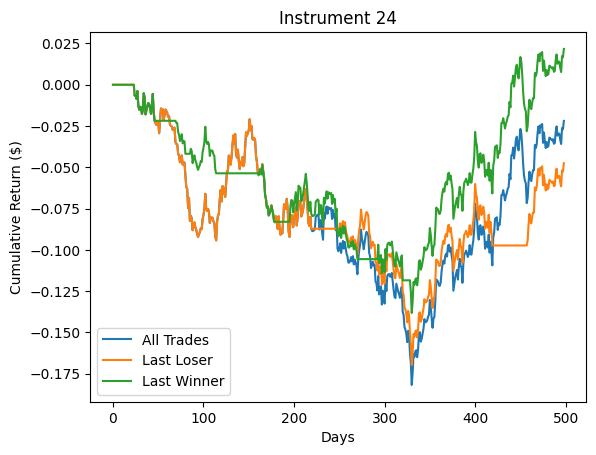

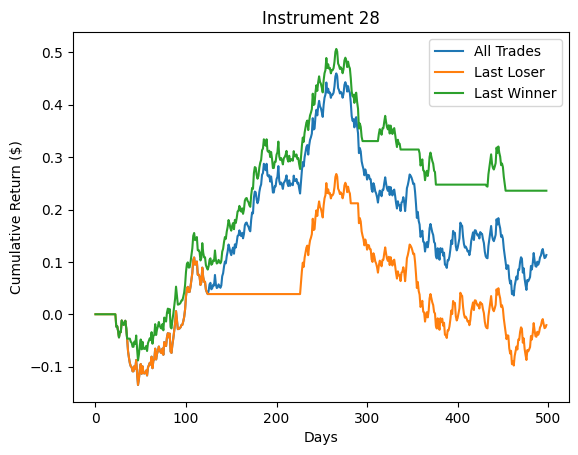

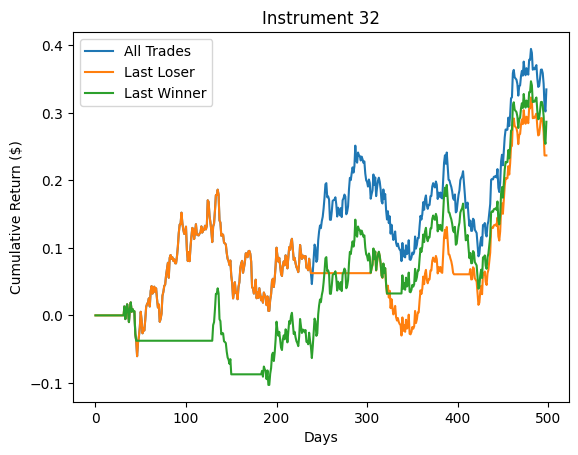

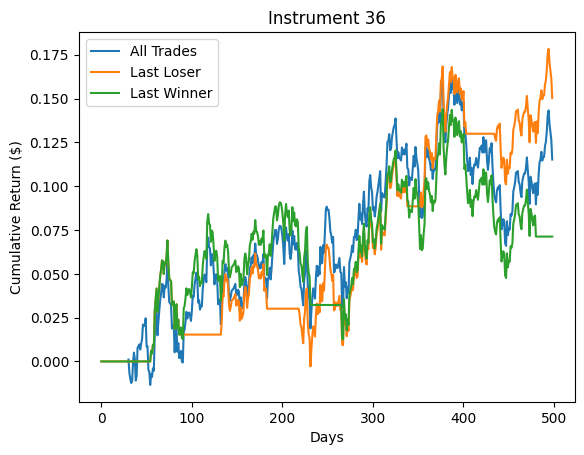

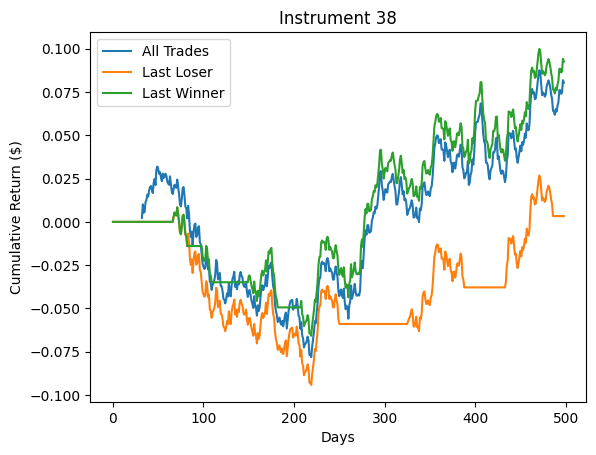

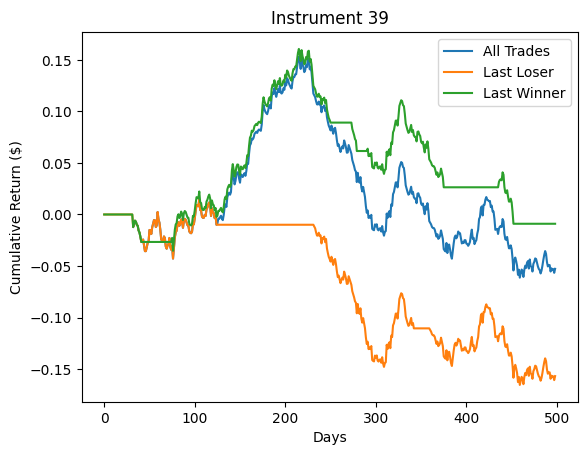

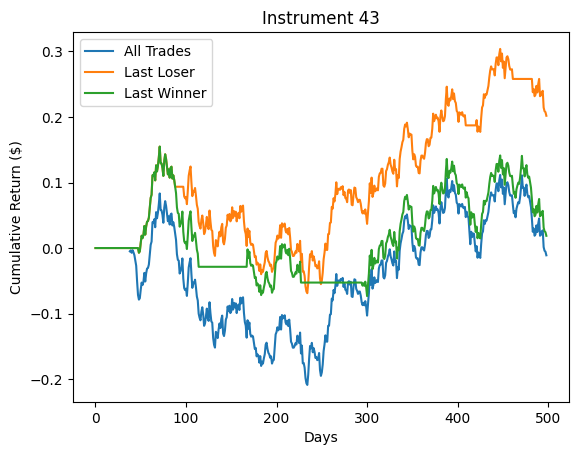

In [48]:
def plot_db_variations() -> None:
	# Get Price History
	price_history: Dict[int, DataFrame] = get_price_history()

	# Get returns
	for instrument_no in allocated_instruments:
		price_history[instrument_no]["returns"] = (np.log(price_history[instrument_no]["price"]).diff
			   ().shift(-1))

	# Get Strategy Output for normal Donchian Breakout
	lookbacks: Dict[int, int] = {instrument_no: 24 for instrument_no in allocated_instruments}
	strategy_output: Dict[int, DataFrame] = donchian_breakout(price_history,lookbacks)

	# Get strategy output with trade dependence
	signals: Dict[int, ndarray] = {instrument_no: strategy_output[instrument_no]["signal"].to_numpy()
		   for instrument_no in allocated_instruments}
	last_lose_signals: Dict[int, ndarray] = last_trade_adj_signal(strategy_output, signals, False)
	last_win_signals: Dict[int, ndarray] = last_trade_adj_signal(strategy_output, signals, True)

	for instrument_no in allocated_instruments:
		strategy_output[instrument_no]["last_lose"] = last_lose_signals[instrument_no]
		strategy_output[instrument_no]["last_win"] = last_win_signals[instrument_no]

	# Get returns for each strategy type
	original: Dict[int, Series] = {
		instrument_no: (strategy_output[instrument_no]["returns"] * 
					   strategy_output[instrument_no]["signal"]) for instrument_no in allocated_instruments
	}
	lose: Dict[int, Series] = {
		instrument_no: (strategy_output[instrument_no]["returns"] * 
						strategy_output[instrument_no]["last_lose"]) for instrument_no in 
						allocated_instruments
	}
	win: Dict[int, Series] = {
		instrument_no: (strategy_output[instrument_no]["returns"] * 
						strategy_output[instrument_no]["last_win"]) for instrument_no in allocated_instruments
	}

	# Output profit factors
	print("====================")
	for instrument_no in allocated_instruments:
		original_profit_factor: float = (original[instrument_no][original[instrument_no] > 0].sum() /
			 original[instrument_no][original[instrument_no] < 0].abs().sum())
		lose_profit_factor: float = (lose[instrument_no][lose[instrument_no] > 0].sum() / 
			 lose[instrument_no][lose[instrument_no] < 0].abs().sum())
		win_profit_factor: float = (win[instrument_no][win[instrument_no] > 0].sum() / 
			win[instrument_no][win[instrument_no] < 0].abs().sum())
		
		print(f"INSTRUMENT: {instrument_no}")
		print(f"Original Profit Factor: {original_profit_factor}")
		print(f"Last Lose Profit Factor: {lose_profit_factor}")
		print(f"Last Win Profit Factor: {win_profit_factor}")
		print("====================")


	# Plot original, last lose and last win trades
	for instrument_no in allocated_instruments:
		original[instrument_no].cumsum().plot(label="All Trades")
		lose[instrument_no].cumsum().plot(label="Last Loser")
		win[instrument_no].cumsum().plot(label="Last Winner")
		plt.title(f"Instrument {instrument_no}")
		plt.xlabel("Days")
		plt.ylabel("Cumulative Return ($)")
		plt.legend()
		plt.show()

plot_db_variations()

### Grid Searching for the best lookback and best strategy type for each instrument (Optimised 
for Profit Factor)

In [58]:
def perform_grid_search() -> None:
	best_params: Dict[str, List[int | float | str]] = {}
	best_params["Instrument No."]: List[int] = allocated_instruments
	best_params["DB Type"]: List[str] = ["All Trades"] * len(allocated_instruments)
	best_params["Best Lookback"]: List[int] = [12] * len(allocated_instruments)
	best_params["Profit Factor"]: List[float] = [-10000000.0] * len(allocated_instruments)
	best_params["Sharpe Ratio"]: List[float] = [-100000.0] * len(allocated_instruments)
	
	for lookback in range(12, 169):
		# Get Price History
		price_history: Dict[int, DataFrame] = get_price_history()

		# Get returns
		for instrument_no in allocated_instruments:
			price_history[instrument_no]["returns"] = (np.log(price_history[instrument_no]["price"]).diff
															   ().shift(-1))

		# Get Strategy Output for normal Donchian Breakout
		lookbacks: Dict[int, int] = {instrument_no: lookback for instrument_no in 
									 allocated_instruments}
		strategy_output: Dict[int, DataFrame] = donchian_breakout(price_history,lookbacks)

		# Get strategy output with trade dependence
		signals: Dict[int, ndarray] = {instrument_no: strategy_output[instrument_no]["signal"].to_numpy()
									   for instrument_no in allocated_instruments}
		last_lose_signals: Dict[int, ndarray] = last_trade_adj_signal(strategy_output, signals, False)
		last_win_signals: Dict[int, ndarray] = last_trade_adj_signal(strategy_output, signals, True)

		for instrument_no in allocated_instruments:
			strategy_output[instrument_no]["last_lose"] = last_lose_signals[instrument_no]
			strategy_output[instrument_no]["last_win"] = last_win_signals[instrument_no]

		# Get returns for each strategy type
		original: Dict[int, Series] = {
			instrument_no: (strategy_output[instrument_no]["returns"] *
							strategy_output[instrument_no]["signal"]) for instrument_no in allocated_instruments
		}
		lose: Dict[int, Series] = {
			instrument_no: (strategy_output[instrument_no]["returns"] *
							strategy_output[instrument_no]["last_lose"]) for instrument_no in
			allocated_instruments
		}
		win: Dict[int, Series] = {
			instrument_no: (strategy_output[instrument_no]["returns"] *
							strategy_output[instrument_no]["last_win"]) for instrument_no in allocated_instruments
		}
		
		# Get Profit Factor and adjust best params
		for instrument_no in allocated_instruments:
			instrument_no_idx: int = allocated_instruments.index(instrument_no)
			original_profit_factor: float
			lose_profit_factor: float
			win_profit_factor: float
			
			original_profit_factor_denom: float = original[instrument_no][original[instrument_no]
																		  < 0].abs().sum()
			lose_profit_factor_denom: float = (lose[instrument_no][lose[instrument_no] < 0].abs()
											   .sum())
			win_profit_factor_denom: float = (win[instrument_no][win[instrument_no] < 0].abs()
											  .sum())
			if original_profit_factor_denom == 0:
				original_profit_factor = np.nan
			else:
				original_profit_factor: float = (original[instrument_no][original[instrument_no] 
						 > 0].sum() / original_profit_factor_denom)
			if lose_profit_factor_denom == 0:
				lose_profit_factor = np.nan
			else:
				lose_profit_factor: float = (lose[instrument_no][lose[instrument_no] > 0].sum() /
										 lose_profit_factor_denom)
			
			if win_profit_factor_denom == 0:
				win_profit_factor = np.nan
			else:
				win_profit_factor: float = (win[instrument_no][win[instrument_no] > 0].sum() /
										win_profit_factor_denom)
			
			if original_profit_factor > best_params["Profit Factor"][instrument_no_idx]:
				best_params["Profit Factor"][instrument_no_idx] = original_profit_factor
				best_params["DB Type"][instrument_no_idx] = "All Trades"
				best_params["Best Lookback"][instrument_no_idx] = lookback
				best_params["Sharpe Ratio"][instrument_no_idx] = (original[instrument_no].mean() 
					  / original[instrument_no].std()) * (252 ** 0.5)
				
			if lose_profit_factor > best_params["Profit Factor"][instrument_no_idx]:
				best_params["Profit Factor"][instrument_no_idx] = lose_profit_factor
				best_params["DB Type"][instrument_no_idx] = "Last Loser"
				best_params["Best Lookback"][instrument_no_idx] = lookback
				best_params["Sharpe Ratio"][instrument_no_idx] = (lose[instrument_no].mean()
					  / lose[instrument_no].std()) * (252 ** 0.5)
			
			if win_profit_factor > best_params["Profit Factor"][instrument_no_idx]:
				best_params["Profit Factor"][instrument_no_idx] = win_profit_factor
				best_params["DB Type"][instrument_no_idx] = "Last Winner"
				best_params["Best Lookback"][instrument_no_idx] = lookback
				best_params["Sharpe Ratio"][instrument_no_idx] = ((win[instrument_no].mean()
					  / win[instrument_no].std()) * (252 ** 0.5))
	
	# Turn Best Params into a DataFrame and output
	best_params_df: DataFrame = pd.DataFrame(best_params)
	print(best_params_df.to_string(index=False))
	
perform_grid_search()

 Instrument No.     DB Type  Best Lookback  Profit Factor  Sharpe Ratio
              0  Last Loser             28       1.221046      1.038159
              1  Last Loser             49       1.251947      1.142954
              6  Last Loser             12       1.224086      1.012907
             10  Last Loser             35       1.181904      0.958930
             12  Last Loser             14       1.188830      1.041861
             14  Last Loser            146       2.280149      1.336432
             16  Last Loser             99       1.195051      0.811078
             17  All Trades             12       1.160282      0.959008
             24 Last Winner             12       1.199404      0.955742
             28 Last Winner             17       1.221428      1.202735
             32 Last Winner             19       1.315976      1.434417
             36 Last Winner             12       1.287282      1.429567
             38 Last Winner             18       1.253975      1